In [1]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 8.2MB 33.5MB/s 


In [2]:
!pip install stop_words

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp37-none-any.whl size=32917 sha256=61c51f9361ebcbac6dbcfb876587937121ea6dda82fc5a5505a830103191ff6d
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [3]:
import re
import string
import pandas as pd
import pymorphy2
from stop_words import get_stop_words 
import numpy as np

In [4]:
df = pd.read_csv('sample_data/Размеченная Таблица 1.csv')

In [5]:
df['company_name'].head(10).reset_index()

,index,company_name
0,0,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""СОВР..."
1,1,ООО ЮГРА СПЕЦАВТОМАТИКА
2,2,ХАНТЫ-МАНСИЙСКАЯ ОКРУЖНАЯ ОБЩЕСТВЕННАЯ ОРГАНИЗ...
3,3,"ООО ""СЛАВИЯПЛЮС"""
4,4,ООО КОМПАНИЯ КРАСКИ
5,5,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ВОСТОК"""
6,6,"ООО ""ГАЗКОНТИНЕНТАЛЬ"""
7,7,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЮЖНЫ..."
8,8,ООО УК КОМПРОМИСС
9,9,"ООО ""ВОЛГА-ВОЛГА ПЛЮС"""


In [6]:
len(df)

100

Обработка данных

In [7]:
len(df['company_id'].unique())

96

In [8]:
df2 = pd.read_csv('sample_data/Размеченная Таблица 2.csv')  

In [10]:
len(labels)

100

In [11]:
sw = set(get_stop_words("ru"))
stpwrds = list(sw) + list(string.punctuation)

In [12]:
morph = pymorphy2.MorphAnalyzer()

In [13]:
corpus = []
# регулярка для поиска слов
regular_expr = r'\w+'
reg_expr_compiled = re.compile(regular_expr)

for raw_text in df['company_name'].values:
    # приводим к нижнему регистру
    # разбиваем текст на слова
    text_by_words = reg_expr_compiled.findall(raw_text)
    raw_text = [i for i in text_by_words if i not in stpwrds]
    raw_text_lower = [morph.parse(i.lower())[0].normal_form for i in raw_text]
    corpus.append(" ".join([i for i in raw_text_lower]))
print(corpus[1])

ооо югра спецавтоматика


In [14]:
texts = corpus
len(texts)

100

In [34]:
#обработка: надо внести новое поле - порядковый номер строки в таблице 2. Потом соединить (merge) Table1 и Table2 по Id. Дальше использовать это новое поле Number_str_Table2 в качестве целевой переменной 
#вычисление target label (выходных меток для обучения)
#96 классов
df2['number_str_table2'] = df2.index
df2
#labels = np.array(df['company_id'])

,id,full_name,short_name,firm_name,en_name,register_date,incorporation_form,unparsed,number_str_table2
0,119652,"""ПРОМИНСТРАХ""","""ПРОМИНСТРАХ""",NaN,NaN,2000-09-12,Общество с ограниченной ответственностью,"115114,ГОРОД МОСКВА,,,,ПРОЕЗД 2-Й ПАВЕЛЕЦКИЙ,Д...",0
1,682935,"""ТУТТА""","""ТУТТА""",NaN,NaN,2012-08-22,Общество с ограниченной ответственностью,"119049,ГОРОД МОСКВА,,,,УЛИЦА ДОНСКАЯ,ДОМ 13,,П...",1
2,1204136,"""ЗЕЛЕНЫЕ ВЕРШИНЫ""","""ЗЕЛЕНЫЕ ВЕРШИНЫ""",NaN,NaN,2006-06-20,Общество с ограниченной ответственностью,"295000,РЕСПУБЛИКА КРЫМ,,ГОРОД СИМФЕРОПОЛЬ,,УЛИ...",2
3,1691699,"""ОБЪЕДИНЕННАЯ ЭНЕРГЕТИЧЕСКАЯ КОМПАНИЯ""","""ОЭК""",NaN,NaN,2005-03-09,Акционерное общество,"115035,ГОРОД МОСКВА,,,,НАБЕРЕЖНАЯ РАУШСКАЯ,8,,",3
4,1752333,"""АТОМЭНЕРГОСБЫТ""","""АТОМЭНЕРГОСБЫТ""",NaN,NaN,2001-07-13,Акционерное общество,"115432,ГОРОД МОСКВА,,,,ПРОЕЗД ПРОЕКТИРУЕМЫЙ 40...",4
...,...,...,...,...,...,...,...,...,...
91,14366175,"""МЕРКУРИЙ""","""МЕРКУРИЙ""",NaN,NaN,2018-11-02,Общество с ограниченной ответственностью,"390020,ОБЛАСТЬ РЯЗАНСКАЯ,,ГОРОД РЯЗАНЬ,,ПРОЕЗД...",91
92,14375559,"""ЛИОН""","""ЛИОН""",NaN,NaN,2018-11-14,Общество с ограниченной ответственностью,"119049,ГОРОД МОСКВА,,,,УЛИЦА МЫТНАЯ,ДОМ 28,СТР...",92
93,14387369,"""КАРБЕРУ.РУ""","""КАРБЕРУ.РУ""",NaN,NaN,2018-11-22,Общество с ограниченной ответственностью,"295053,РЕСПУБЛИКА КРЫМ,,ГОРОД СИМФЕРОПОЛЬ,,УЛИ...",93
94,14583831,"""ТРАНСПОРТНАЯ КОМПАНИЯ ЮГРАСПЕЦТРАНС""","""ТРАНСПОРТНАЯ КОМПАНИЯ ЮГРАСПЕЦТРАНС""",NaN,NaN,2019-06-26,Общество с ограниченной ответственностью,"628007,АВТОНОМНЫЙ ОКРУГ ХАНТЫ-МАНСИЙСКИЙ АВТОН...",94


In [37]:
df = df.merge(df2, left_on="company_id", right_on="id")

In [58]:
len(df)

100

In [38]:
df.head()

,company_id,company_name,address,id,full_name,short_name,firm_name,en_name,register_date,incorporation_form,unparsed,number_str_table2
0,9514030,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""СОВР...","628011, ХАНТЫ-МАНСИЙСК Г, ЛЕНИНА УЛ,106, 1",9514030,"""СОВРЕМЕННЫЕ СИСТЕМЫ БЕЗОПАСНОСТИ - ЮГРА""","""ССБ-ЮГРА""",NaN,NaN,2014-08-12,Общество с ограниченной ответственностью,"628007,АВТОНОМНЫЙ ОКРУГ ХАНТЫ-МАНСИЙСКИЙ АВТОН...",30
1,13530883,ООО ЮГРА СПЕЦАВТОМАТИКА,"628007,86, ХАНТЫ-МАНСИЙСК, ПАТРИСА ЛУМУМБЫ, 78",13530883,"""ЮГРА СПЕЦАВТОМАТИКА""","""ЮГРА СПЕЦАВТОМАТИКА""",NaN,NaN,2016-11-28,Общество с ограниченной ответственностью,"628007,АВТОНОМНЫЙ ОКРУГ ХАНТЫ-МАНСИЙСКИЙ АВТОН...",74
2,4936728,ХАНТЫ-МАНСИЙСКАЯ ОКРУЖНАЯ ОБЩЕСТВЕННАЯ ОРГАНИЗ...,"РОССИЯ,628007, ХАНТЫ-МАНСИЙСК Г, МИРА УЛ,59",4936728,ХАНТЫ-МАНСИЙСКАЯ ОКРУЖНАЯ ОБЩЕСТВЕННАЯ ОРГАНИЗ...,ХМОО РСМ,NaN,NaN,2010-05-07,NaN,"628007,АВТОНОМНЫЙ ОКРУГ ХАНТЫ-МАНСИЙСКИЙ АВТОН...",21
3,9552692,"ООО ""СЛАВИЯПЛЮС""","РОССИЯ,298186,КРЫМ РЕСП, ФЕОДОСИЯ Г,КОКТЕБЕЛЬ ...",9552692,"""СЛАВИЯПЛЮС""","""СЛАВИЯПЛЮС""",NaN,NaN,2014-10-08,Общество с ограниченной ответственностью,"298186,РЕСПУБЛИКА КРЫМ,,ГОРОД ФЕОДОСИЯ,ПОСЕЛОК...",43
4,9835155,ООО КОМПАНИЯ КРАСКИ,"295015,91, СИМФЕРОПОЛЬ Г, СЕВАСТОПОЛЬСКАЯ УЛ,2...",9835155,"""КОМПАНИЯ ""КРАСКИ""","""КОМПАНИЯ ""КРАСКИ""",NaN,NaN,2003-02-24,Общество с ограниченной ответственностью,"295024,РЕСПУБЛИКА КРЫМ,,ГОРОД СИМФЕРОПОЛЬ,,УЛИ...",52


In [59]:
labels = np.array(df['number_str_table2'])
len(labels)

100

Конструирование нейронной сети

In [40]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical 

In [41]:
maxlen = 100
training_samples = 70
validation_samples = 30
max_words = 5000
drop_embed = 0.2
n_conv = 256
k_conv = 3 

In [42]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [43]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 210 unique tokens.


In [44]:
data = pad_sequences(sequences, maxlen=maxlen)

In [45]:
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (100, 100)
Shape of label tensor: (100,)


In [46]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [70]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [71]:
y_val

array([38, 56, 78, 58, 81, 90,  2,  0, 68,  1, 83,  6, 36, 32, 42, 93, 60,
       25,  4, 20, 31, 16, 75, 22, 67, 34,  8, 49, 57, 77])

In [72]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [75]:
y_val.shape

(30, 94)

In [50]:
embedding_dim = 64

In [53]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
from sklearn.metrics import roc_auc_score, roc_curve
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import SpatialDropout1D

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(SpatialDropout1D(drop_embed))

model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(96, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 64)           320000    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 100, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 98, 256)           49408     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 96)                24672     
Total params: 394,080
Trainable params: 394,080
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.compile(optimizer='rmsprop', 
             loss='categorical_crossentropy',
             metrics=['acc'])

In [55]:
x_val.shape

(30, 100)

In [56]:
y_val.shape

(30, 89)

In [77]:
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=32)
#                    validation_data=(x_val, y_val))

Epoch 1/100
3/3 [==============================] - 0s 7ms/step - loss: 4.2325 - acc: 0.1286
Epoch 2/100
3/3 [==============================] - 0s 6ms/step - loss: 4.1815 - acc: 0.1286
Epoch 3/100
3/3 [==============================] - 0s 6ms/step - loss: 4.1279 - acc: 0.1000
Epoch 4/100
3/3 [==============================] - 0s 8ms/step - loss: 4.0719 - acc: 0.0857
Epoch 5/100
3/3 [==============================] - 0s 6ms/step - loss: 4.0221 - acc: 0.0857
Epoch 6/100
3/3 [==============================] - 0s 6ms/step - loss: 3.9669 - acc: 0.0857
Epoch 7/100
3/3 [==============================] - 0s 6ms/step - loss: 3.9206 - acc: 0.1000
Epoch 8/100
3/3 [==============================] - 0s 6ms/step - loss: 3.8550 - acc: 0.1000
Epoch 9/100
3/3 [==============================] - 0s 6ms/step - loss: 3.8024 - acc: 0.1143
Epoch 10/100
3/3 [==============================] - 0s 6ms/step - loss: 3.7516 - acc: 0.1000
Epoch 11/100
3/3 [==============================] - 0s 7ms/step - loss: 3.6896 

In [78]:
import matplotlib.pyplot as plt 

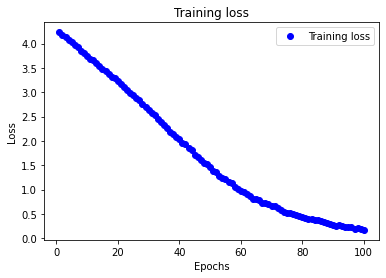

In [80]:
loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

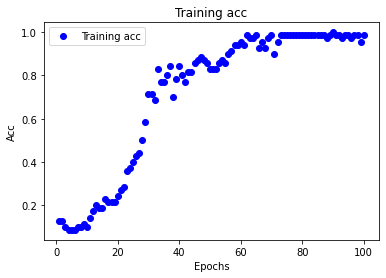

In [81]:
plt.clf()
acc = history.history['acc']
#val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

Вывод: на обучающей выборке получается хорошая точность (accuracy) 98%. К сожалению, набор данных очень маленький из 100 элементов (при общем количестве компаний 100). В результате я не смог разбить исходный набор на обучающий и тестовый (валидационный). Обычно 30% данных резервируется для проверки модели на предмет переобучения и качество модели оценивается на тестовом наборе, на котором модель не училась. Здесь я не могу это сделать, поэтому модель может быть переобучена (overfitting), как студент которые заучил вызубрил все ответы к экзамену, но не понял общие закономерности и любое отклонение от стандартного вопроса ставит его в тупик.      